# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

/Users/eugenetang/miniconda3/envs/W207/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


Load feature names.

In [2]:
feature_names = []
with open('../Datasets/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print('Loaded feature names:', len(feature_names))

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('../Datasets/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

k  | Fraction of Total Variance Explained
-----------------------------------------
 1 | 0.16404
 2 | 0.29728
 3 | 0.39901
 4 | 0.46965
 5 | 0.50831
 6 | 0.54512
 7 | 0.57640
 8 | 0.60374
 9 | 0.62991
10 | 0.65221
11 | 0.67270
12 | 0.69138
13 | 0.70872
14 | 0.72557
15 | 0.74076
16 | 0.75584
17 | 0.77013
18 | 0.78425
19 | 0.79750
20 | 0.80897
21 | 0.81968
22 | 0.83034
23 | 0.84075
24 | 0.85068
25 | 0.85976
26 | 0.86846
27 | 0.87641
28 | 0.88417
29 | 0.89155
30 | 0.89855
31 | 0.90496
32 | 0.91111
33 | 0.91683
34 | 0.92217
35 | 0.92743
36 | 0.93245
37 | 0.93744
38 | 0.94200
39 | 0.94653
40 | 0.95093
41 | 0.95512
42 | 0.95910
43 | 0.96280
44 | 0.96640
45 | 0.96978
46 | 0.97277
47 | 0.97549
48 | 0.97784
49 | 0.98006
50 | 0.98210


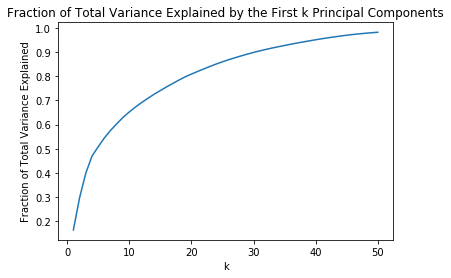

In [4]:
def P1():
    # train pca
    pca = PCA()
    pca.fit(train_data)
    
    # get total variance for k from 1 to 50
    print('k  | Fraction of Total Variance Explained')
    print('-----------------------------------------')
    fraction_explained = []
    for k in range(1,51):
        fraction_explained_k = sum(pca.explained_variance_ratio_[0:k])
        fraction_explained.append(fraction_explained_k)
        print('{:2d} | {:.5f}'.format(k, fraction_explained_k))
    plt.plot(list(range(1,51)), fraction_explained)
    plt.title('Fraction of Total Variance Explained by the First k Principal Components')
    plt.xlabel("k")
    plt.ylabel("Fraction of Total Variance Explained")
    plt.show()

P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

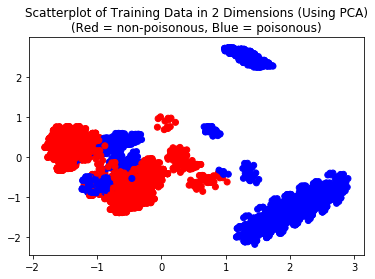

In [14]:
def P2():
    pca = PCA(n_components=2)
    train_data_d2 = pca.fit_transform(train_data)
    cs = ['b' if poisonous == 1 else 'r' for poisonous in train_labels]
    plt.scatter(train_data_d2[:, 0], train_data_d2[:, 1], c=cs)
    plt.title('Scatterplot of Training Data in 2 Dimensions (Using PCA)\n(Red = non-poisonous, Blue = poisonous)')
    plt.show()
    
P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

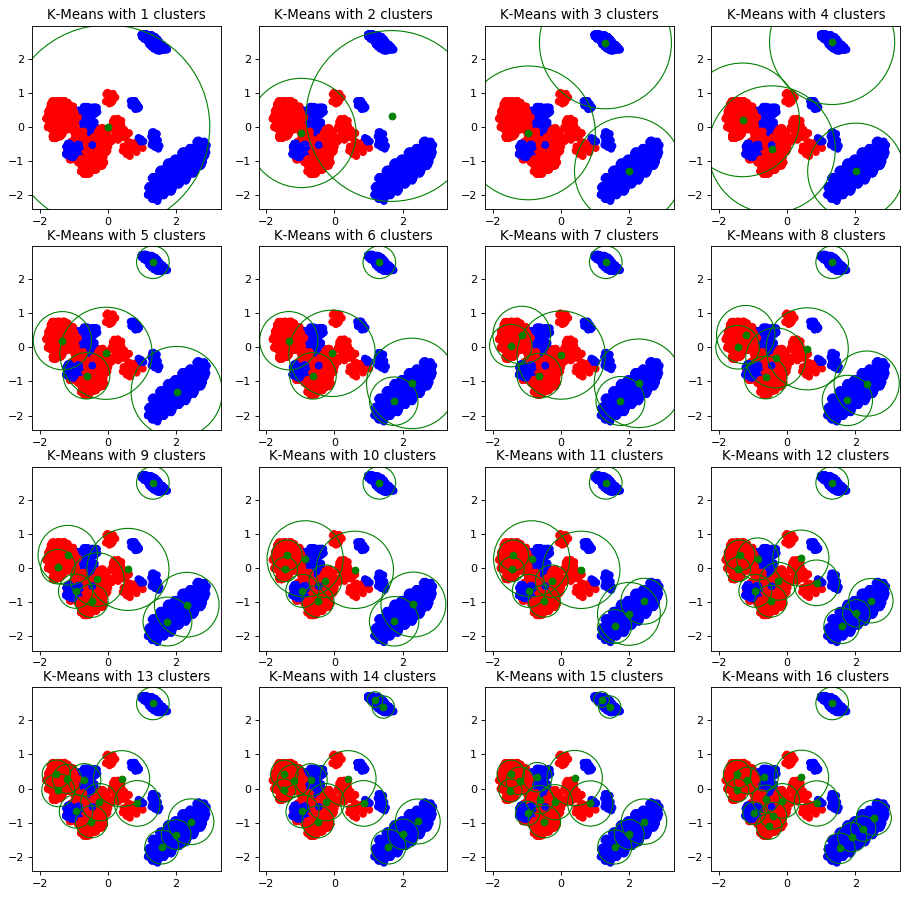

In [15]:
from matplotlib.patches import Circle
def P3():
    # run pca and setup training data for plotting
    pca = PCA(n_components=2)
    train_data_d2 = pca.fit_transform(train_data)
    xs = [d[0] for d in train_data_d2]
    ys = [d[1] for d in train_data_d2]
    cs = ['b' if poisonous == 1 else 'r' for poisonous in train_labels]
    
    # plot k-means for 1-16 clusters
    plt.figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')
    for n in range(1,17):
        
        # plot setup
        plt.subplot(4, 4, n)
        plt.axis('equal')
        plt.title('K-Means with {} clusters'.format(n))
        fig = plt.gcf()
        ax = fig.gca()
        
        # train kmeans and get clusters / distances
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(train_data_d2)
        clusters = kmeans.predict(train_data_d2)
        distances = kmeans.transform(train_data_d2)
        
        # get furthest point from each cluster
        cluster_to_furthest_point = { i:{'distance':0, 'point': None} for i in range(n) }
        for point, cluster, distance in zip(train_data_d2, clusters, distances):
            if distance[cluster] > cluster_to_furthest_point[cluster]['distance']:
                cluster_to_furthest_point[cluster]['distance'] = distance[cluster]
                cluster_to_furthest_point[cluster]['point'] = point
        
        # plot
        plt.scatter(xs, ys, c=cs)
        plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='g')
        for cluster, furthest_point_info in cluster_to_furthest_point.items():
            furthest_point = furthest_point_info['point']
            circle = plt.Circle(tuple(kmeans.cluster_centers_[cluster]), furthest_point_info['distance'], color='g', fill=False)
            ax.add_artist(circle)
    plt.show()


P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

/Users/eugenetang/miniconda3/envs/W207/lib/python3.7/site-packages/matplotlib/contour.py:1544: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


Showing Negative log-likelihood predicted by a GMM on the positive mushroom samples.


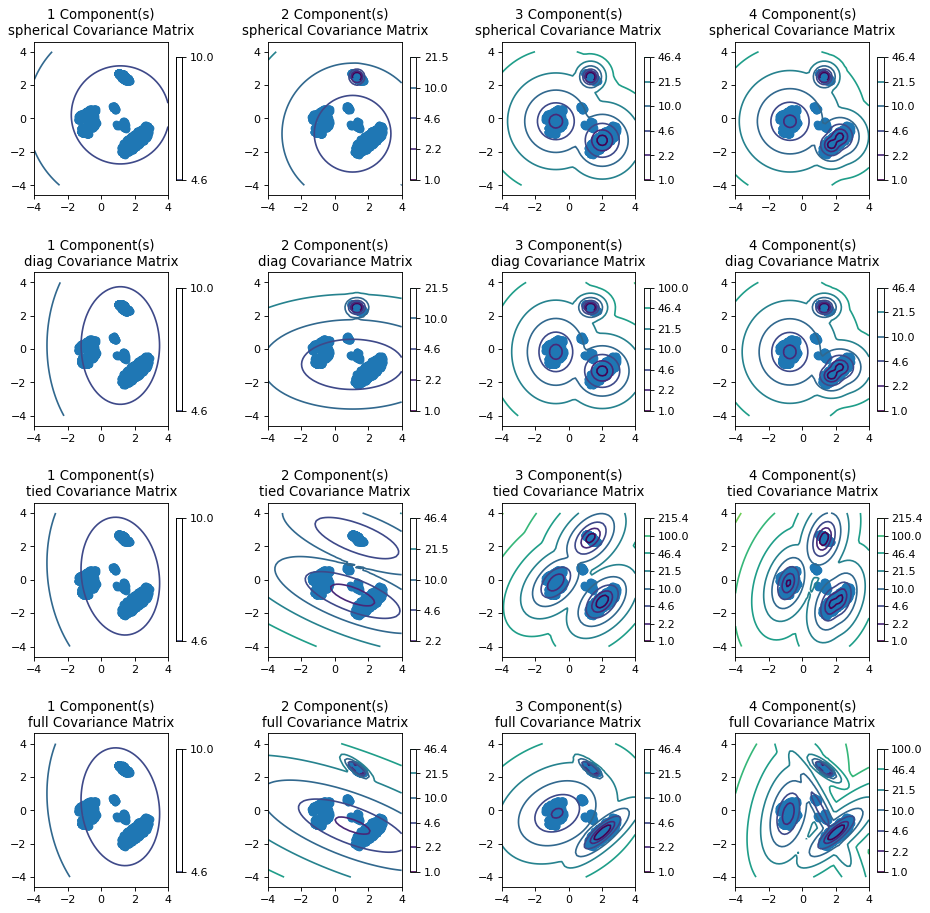

In [7]:
# note: some of the code here was derived from the code on sklearn: https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py
def P4():
    # run pca and setup training data for plotting
    pca = PCA(n_components=2)
    train_data_d2 = pca.fit_transform(train_data)
    train_data_d2_pos = train_data_d2[train_labels==1]
    
    plt.figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')
    plt.subplots_adjust(wspace=0.4, hspace=0.5)
    
    # plot density contours for the desired covariance matrix types and number of components
    cov_matrix_types = ['spherical', 'diag', 'tied', 'full']
    plot_id=1
    for matrix_type in cov_matrix_types:
        for n_components in range(1,5):
            # plot setup
            plt.subplot(4, 4, plot_id)
            plt.axis('equal')
            plt.title('{} Component(s)\n{} Covariance Matrix'.format(n_components, matrix_type))


            # fit a Gaussian Mixture Model with provided components and covariance matrix type
            gmm = GaussianMixture(n_components=n_components, covariance_type=matrix_type)
            gmm.fit(train_data_d2_pos)

            # display predicted scores by the model as a contour plot
            x = np.linspace(-4., 4.)
            y = np.linspace(-4., 4.)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -gmm.score_samples(XX)
            Z = Z.reshape(X.shape)

            CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
            CB = plt.colorbar(CS, shrink=0.8, format='%.1f', extend='both')
            plt.scatter(train_data_d2_pos[:, 0], train_data_d2_pos[:, 1])
            plot_id += 1
    print('Showing Negative log-likelihood predicted by a GMM on the positive mushroom samples.')
    plt.show()
P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [8]:
def P5():
    # run pca and setup training and dev data
    pca = PCA(n_components=2)
    train_data_d2 = pca.fit_transform(train_data)
    train_data_d2_pos = train_data_d2[train_labels==1]
    train_data_d2_neg = train_data_d2[train_labels==0]
    test_data_d2 = pca.transform(test_data)
    
    # fit a Gaussian Mixture Model for positive and negative examples
    gmm_pos = GaussianMixture(n_components=4, covariance_type='full')
    gmm_neg = GaussianMixture(n_components=4, covariance_type='full')
    gmm_pos.fit(train_data_d2_pos)
    gmm_neg.fit(train_data_d2_neg)
    
    # get predictions
    pos_scores = gmm_pos.score_samples(test_data_d2)
    neg_scores = gmm_neg.score_samples(test_data_d2)    
    predictions = pos_scores > neg_scores
    
    correct = test_labels == predictions
    print('Our two GMM models has an accuracy of {:.6f} on the test data.'.format(np.sum(correct)/len(correct)))
    
P5()

Our two GMM models has an accuracy of 0.936833 on the test data.


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [9]:
# run pca, train gmm on the data, and return the accuracy
def train_and_get_accuracy(pca_n, gmm_n, gmm_matrix_type):
    
    # run pca and setup training data
    pca = PCA(n_components=pca_n)
    train_data_d2 = pca.fit_transform(train_data)
    train_data_d2_pos = train_data_d2[train_labels==1]
    train_data_d2_neg = train_data_d2[train_labels==0]
    test_data_d2 = pca.transform(test_data)
    
    # fit a Gaussian Mixture Model for positive and negative examples
    gmm_pos = GaussianMixture(n_components=gmm_n, covariance_type=gmm_matrix_type)
    gmm_neg = GaussianMixture(n_components=gmm_n, covariance_type=gmm_matrix_type)
    gmm_pos.fit(train_data_d2_pos)
    gmm_neg.fit(train_data_d2_neg)
    
    # get predictions
    pos_scores = gmm_pos.score_samples(test_data_d2)
    neg_scores = gmm_neg.score_samples(test_data_d2)    
    predictions = pos_scores > neg_scores
    
    correct = test_labels == predictions
    
    return np.sum(correct)/len(correct)

def P6():
    # search space
    # we will iterate over all possible values of n_components (for pca and gmm) such that 
    # the number of parameters is < 50.
    gmm_matrix_types = ['spherical', 'diag', 'tied', 'full']    
    
    # iterate through possible combinations to get maximum-accuracy combination
    # if we were to use such an algorithm in reality, ideally we would like to run CV on the 
    # training set to avoid overfitting on the test dataset. However, for the purposes, it 
    # seems that this question desires measuring the accuracy on the test set for the different
    # parameter combinations.
    max_accuracy = 0
    max_accuracy_params = {'pca_n_components': None, 'gmm_n_components': None, 'gmm_covariance_type': None}
    for pca_n in range(1,50):
        # max 50 parameters
        max_gmm_n = int(50/(2*2*pca_n))
        for gmm_n in range(1,max_gmm_n+1):
            for gmm_matrix_type in gmm_matrix_types:
                accuracy = train_and_get_accuracy(pca_n, gmm_n, gmm_matrix_type)
                if accuracy > max_accuracy:
                    max_accuracy = accuracy
                    max_accuracy_params['pca_n_components'] = pca_n
                    max_accuracy_params['gmm_n_components'] = gmm_n
                    max_accuracy_params['gmm_covariance_type'] = gmm_matrix_type
    print('The GMM models we found with the best accuracy with less than 50 parameters had an accuracy of {:.6f} on the test data.'.format(max_accuracy))
    print('The parameters used in the models were:')
    print(max_accuracy_params)
                    
P6()

The GMM models we found with the best accuracy with less than 50 parameters had an accuracy of 0.969751 on the test data.
The parameters used in the models were:
{'pca_n_components': 4, 'gmm_n_components': 3, 'gmm_covariance_type': 'tied'}
